In [53]:
#importing all necessary packages
import numpy as np
import pandas as pd
import scanpy.api as sc
import scipy
from scipy.misc import factorial
import os
import re

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
sc.settings.figdir="/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/"

scanpy==1.3.1 anndata==0.6.10 numpy==1.15.0 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Functions
## Preprocessing the single cell data

In [54]:
def PreprocessSC(data_path, data_type):
    
    path = data_path
    
    # Build adata
    # var_names = HGNC symbols but adding ENSEMBLE gene IDs additionally
    # obs_names = Cell-IDs
    # -------------------------------------------------------------------- #
    global adata
    
    adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
        
    genes = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')
    adata.var_names = genes[1]
    adata.var['gene_ids'] = genes[0].tolist()  
    adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
    adata.var_names_make_unique()
    
    # -------------------------------------------------------------------- #
    # -------------------------------------------------------------------- #
    # Starting preprocessing
    # Highest expressed genes
    # -------------------------------------------------------------------- #
    sc.pl.highest_expr_genes(adata, n_top=20)
    
    # Filtering based on min. expressed genes per cell and vice versa
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Prepare filtering for mitochondrial genes (based on HGNC)    
    # -------------------------------------------------------------------- #
    hgnc = [name for name in adata.var_names if name.startswith('MT-')]
    hgnc
    a = adata.var[adata.var_names.isin(hgnc)]
    mito_genes = a.index.values.tolist()
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    # Save violin plot 
    # -------------------------------------------------------------------- #
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4, multi_panel=True, save = 'PT_Clust_Violin_Genes_Counts_Mito_' + str(data_type) + '.svg')
    
    # Plot scatter plots
    # -------------------------------------------------------------------- #
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    

In [30]:
## Clustering cells

In [55]:
def ClusterCells (adata_input, cutoff_mito, cutoff_ngenes, data_type, resolution_lv = 1):
    # Filter sc data
    # -----------------------------------------------------------------------
    global adata
    adata = adata_input
    adata = adata[adata.obs['n_genes'] < cutoff_ngenes, :]
    adata = adata[adata.obs['percent_mito'] < cutoff_mito, :]
    # Log raw data and Normalize sc data
    # -----------------------------------------------------------------------
    #adata.raw = sc.pp.log1p(adata, copy=True)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    # Filtering according to HVG
    # -----------------------------------------------------------------------
    filter_result = sc.pp.filter_genes_dispersion(
        adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.filter_genes_dispersion(filter_result)
    adata = adata[:, filter_result.gene_subset]
    # Final step in data scaling and correction
    # -----------------------------------------------------------------------
    sc.pp.log1p(adata)
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    sc.pp.scale(adata, max_value=10)
    
    # Downstream Analysis
    # Calculate PCA
    # -----------------------------------------------------------------------
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata)
    sc.pl.pca_variance_ratio(adata, log=False)
    # Compute Neighbours for LV- clustering
    # -----------------------------------------------------------------------
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.louvain(adata, resolution = resolution_lv)
    # Plot umap embedding of louvain clustering
    # -----------------------------------------------------------------------
    sc.pl.umap(adata, color=['louvain'],save = '_LouvainClustering_'+ str(data_type) +".svg")
    #adata.write(results_file)

In [32]:
## Prepare dotplots for Master GOI's

In [33]:
# Analysis

In [34]:
## Control sample 3

Preprocess and cluster the data.

... reading from cache file ./cache/data-bioinf-projects-data-2018_scanpyTutorial-input-sc_hROHT-S3_CTRL_HRO2-raw_gene_bc_matrices-hg38.e87-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 343052 cells that have less than 1 counts


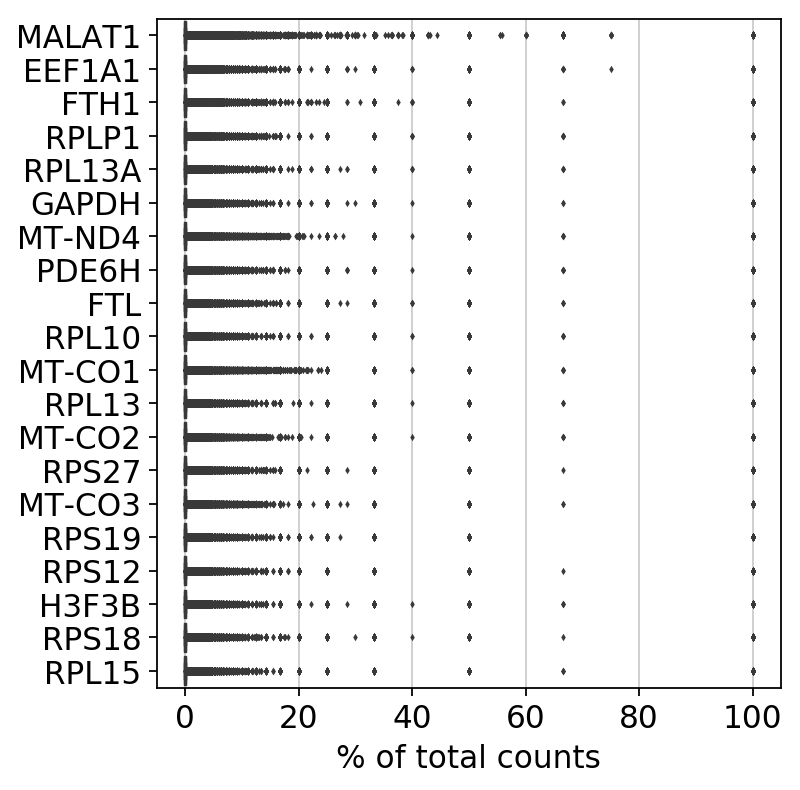

filtered out 728622 cells that have less than 200 genes expressed
filtered out 11909 genes that are detected in less than 3 cells
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/violinPT_Clust_Violin_Genes_Counts_Mito_CTRL_3.svg


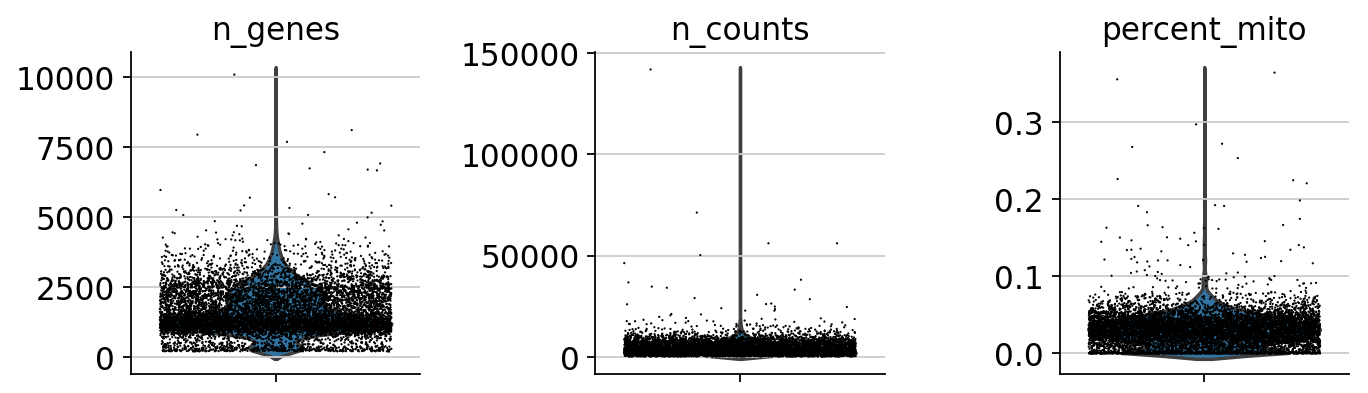

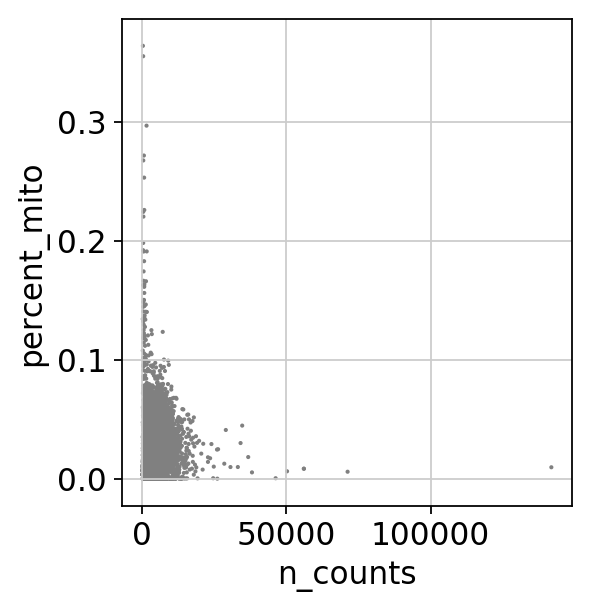

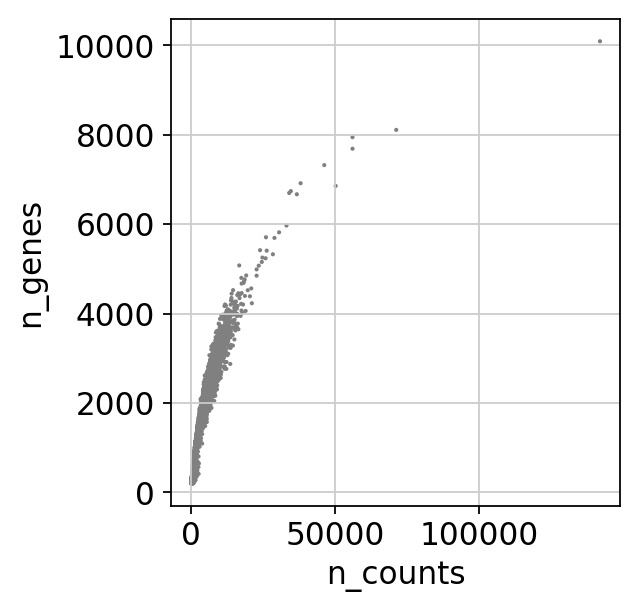

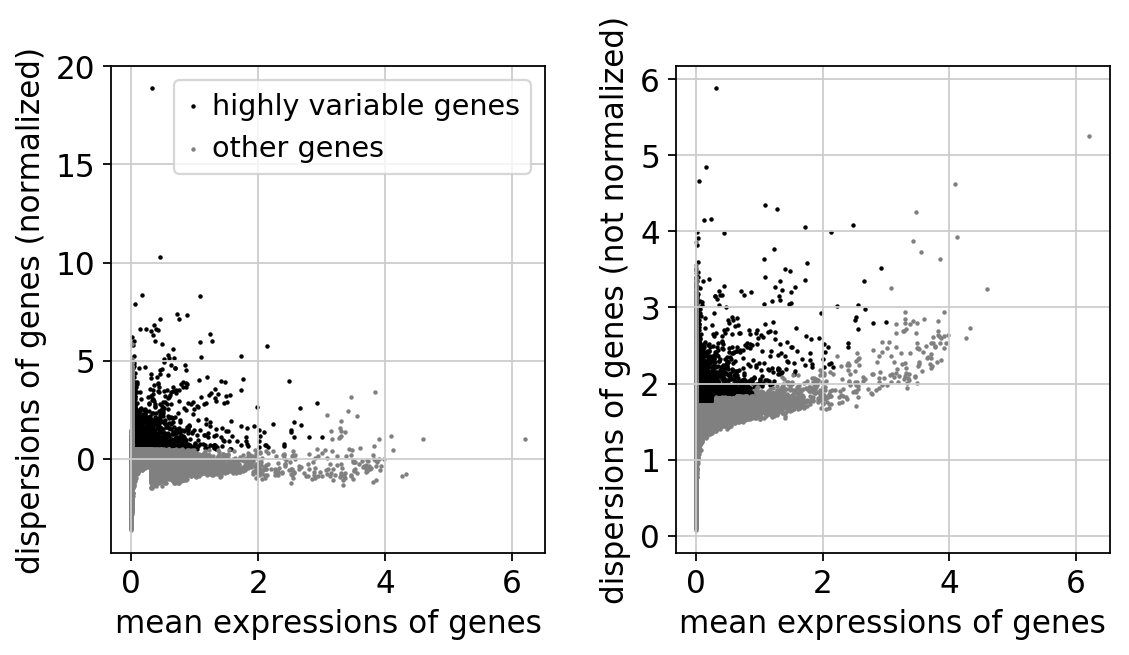

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.71)


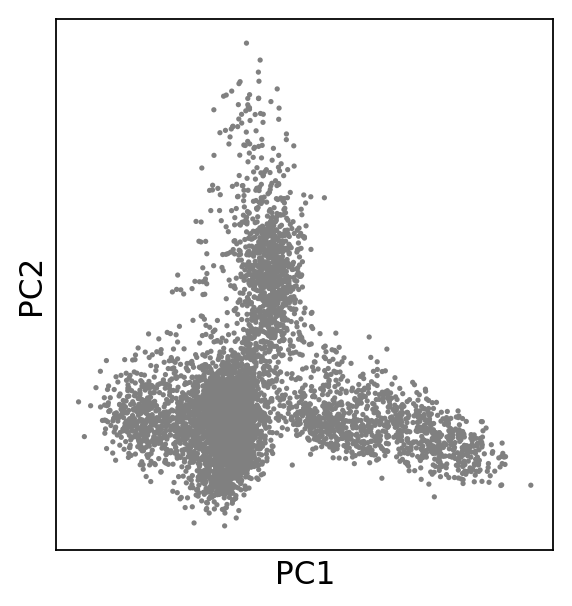

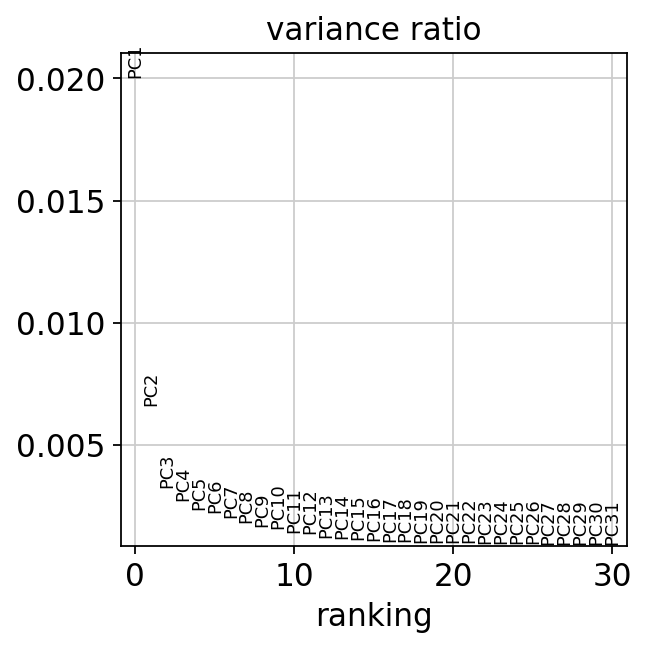

computing neighbors
    using 'X_pca' with n_pcs = 40


/global/apps/bioinf/conda_envs/public/scanpy/scanpy-1.3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:02.43) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.34) --> found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_LouvainClustering_CTRL_3_higherResolution.svg


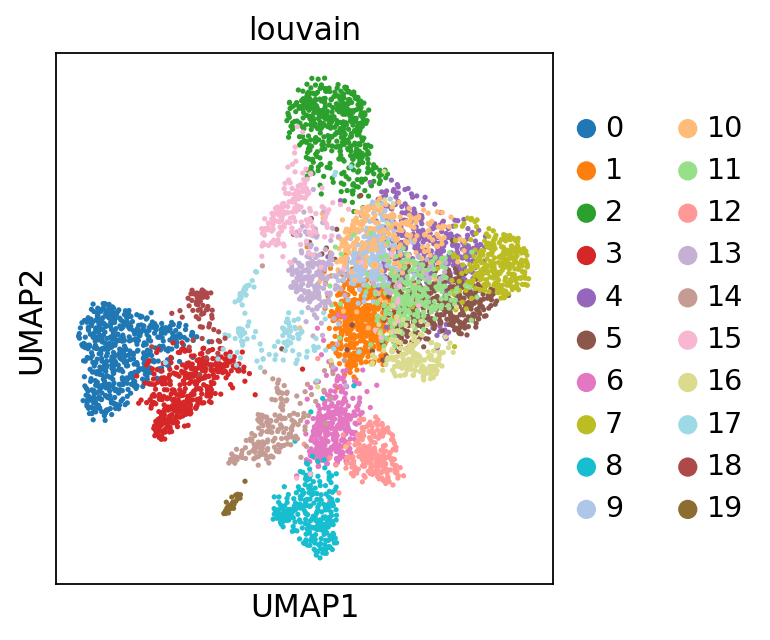

In [56]:
PreprocessSC(data_path = '/data/bioinf/projects/data/2018_scanpyTutorial/input/sc_hROHT/S3_CTRL_HRO2/raw_gene_bc_matrices/hg38.e87/',
             data_type = 'CTRL_3')
ClusterCells(adata_input = adata, 
               cutoff_mito = 0.04, 
               cutoff_ngenes = 2500, 
               resolution_lv = 2, 
             
               data_type = 'CTRL_3_higherResolution')

Prepare the dotplots showing the expression of marker genes across the louvain clusters

According to the result of the Master GOI analysis the Louvain clusters are annotated

... storing 'CaSTLe-Organoid' as categorical
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control3.svg


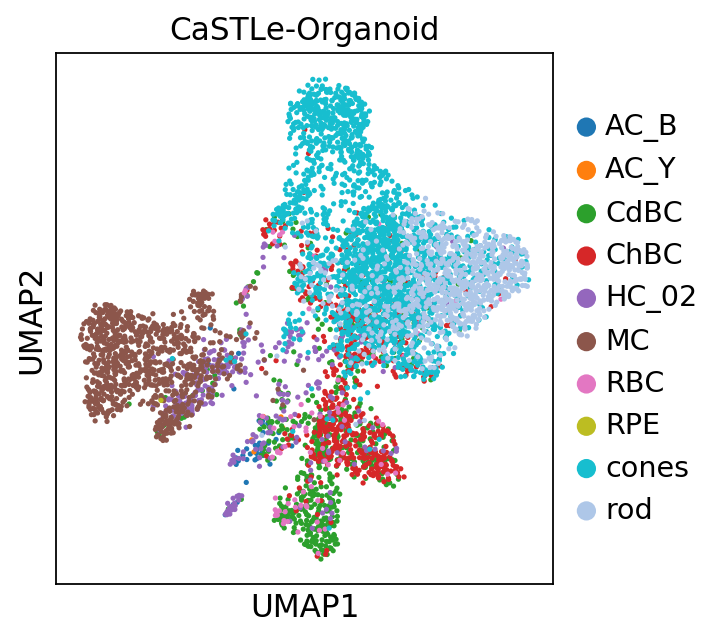

In [57]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_3_Organoid_cellnames.csv")
CaSTLE
adata.obs["CaSTLe-Organoid"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe-Organoid'], save = "_CaSTLe_Annot_subtypes_Control3.svg")

saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control3.svg


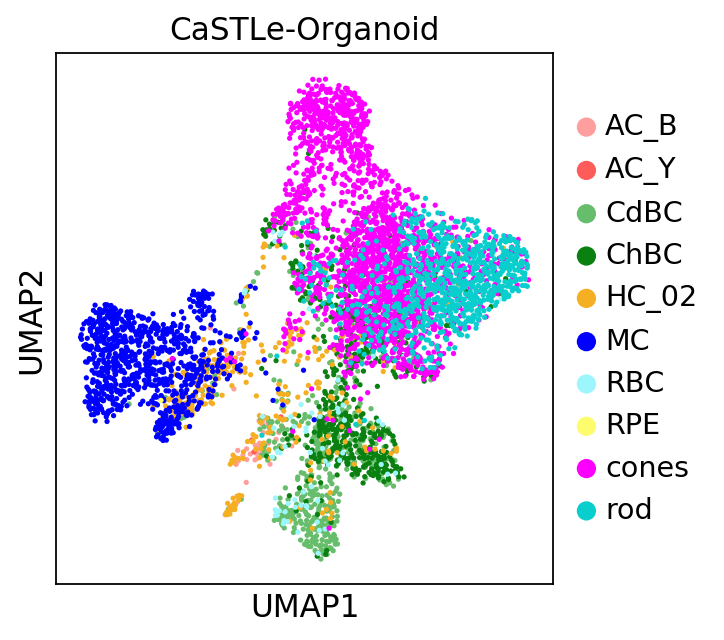

In [58]:
adata.uns['CaSTLe-Organoid_colors'] = ['#FF9E9E',  '#FE5B5B',  
                              '#66BD6B', '#098010', '#F5AF22',  '#0000FF', 
                              '#9CF6FC', '#FCFC6C', '#FC00FF', '#09CECE']
sc.pl.umap(adata, color=['CaSTLe-Organoid'], save = "_CaSTLe_Annot_subtypes_Control3.svg")


In [38]:
adata.write("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/Data/HRO_3_CaSTLe.h5ad")

In [60]:
adata.obs["CaSTLe-Organoid"].to_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/Chapter9_CaSTLe_Annot_HRO3.csv")

... storing 'CaSTLe-Foveal' as categorical
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control3_Fov.svg


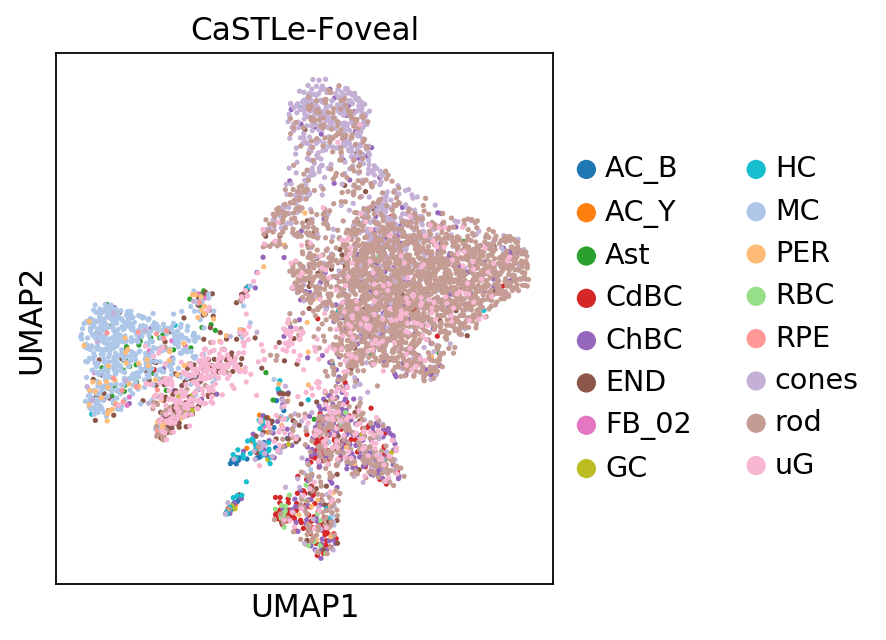

In [39]:
CaSTLE = pd.read_csv("/work/steinheu/2021_HRO_CTRL/RData/CaSTLe_Annot_output_Control_3_Foveal_cellnames.csv")
CaSTLE
adata.obs["CaSTLe-Foveal"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe-Foveal'], save = "_CaSTLe_Annot_subtypes_Control3_Fov.svg")



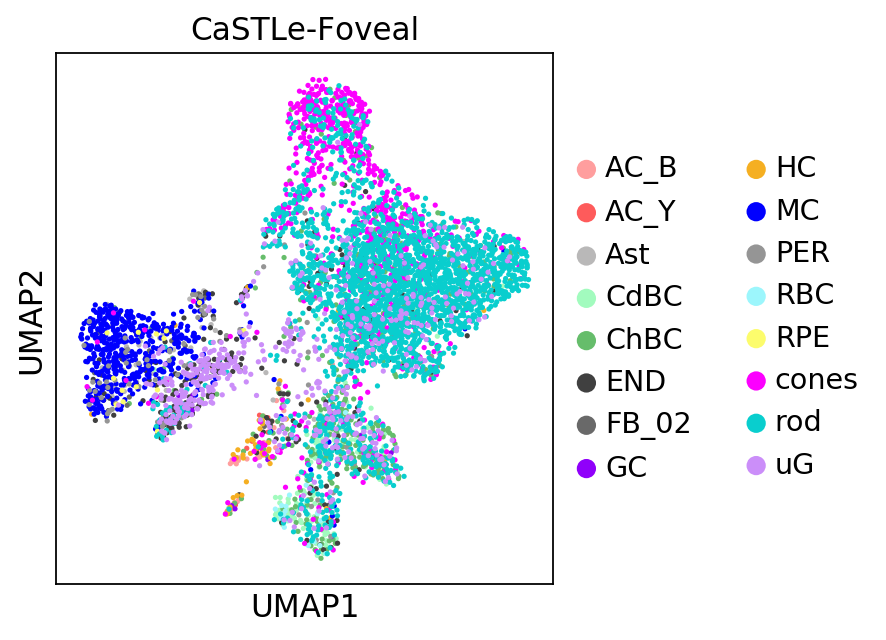

saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control3_Fov.svg


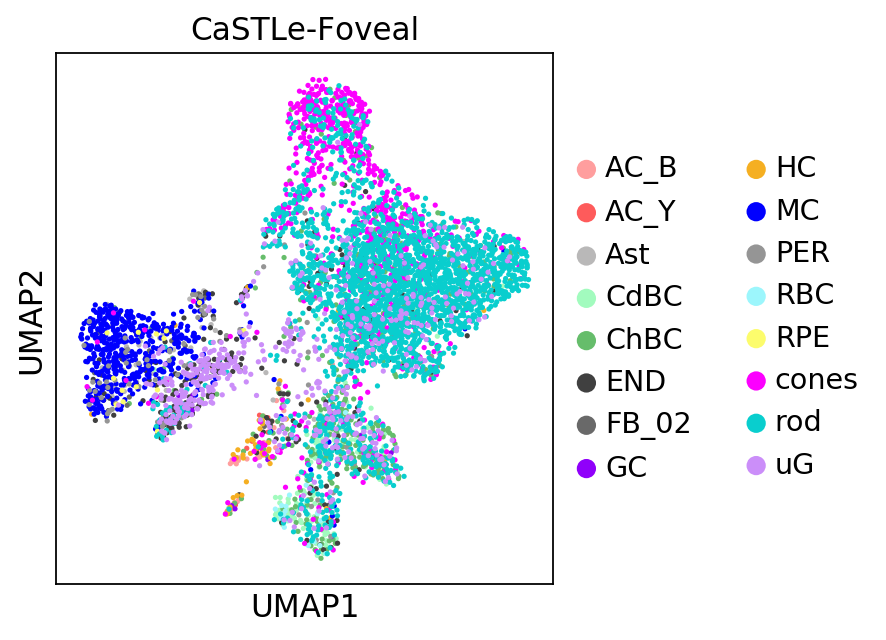

In [40]:
adata.uns['CaSTLe-Foveal_colors'] = ['#FF9E9E',  '#FE5B5B',   '#B9B8B8',
                                 '#A2FBBE', '#66BD6B', '#404040','#696969', '#9000FA',  '#F5AF22', 
                              '#0000FF', '#959595',  '#9CF6FC', '#FCFC6C',
                                   '#FC00FF', '#09CECE', '#CB8EF9']
sc.pl.umap(adata, color=['CaSTLe-Foveal'])

#sc.pl.umap(adata, color=['Compressed'])
sc.pl.umap(adata, color=['CaSTLe-Foveal'], save = "_CaSTLe_Annot_subtypes_Control3_Fov.svg")

... storing 'CaSTLe-Peripheral' as categorical
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control3_Per.svg


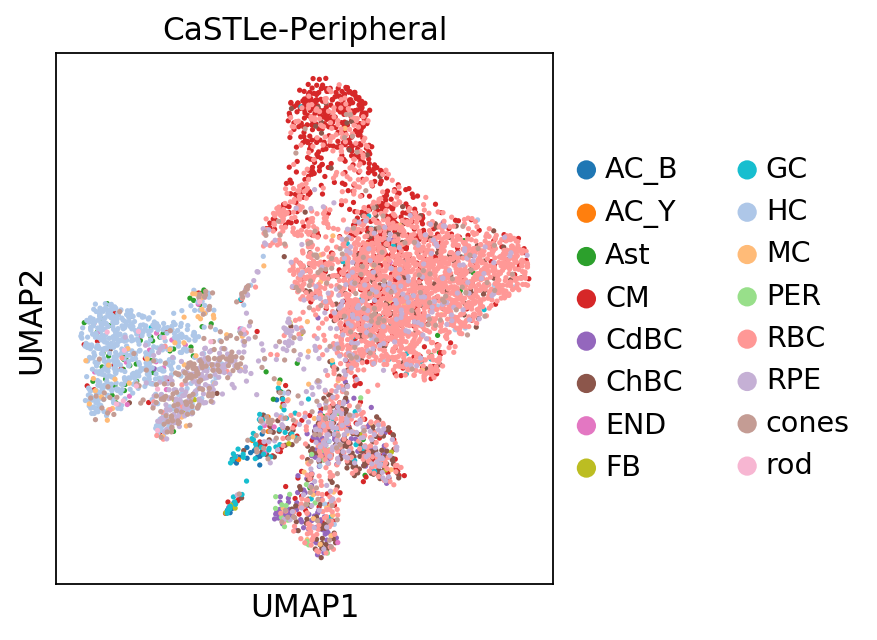

In [41]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_3_Peri_cellnames.csv")
CaSTLE
adata.obs["CaSTLe-Peripheral"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe-Peripheral'], save = "_CaSTLe_Annot_subtypes_Control3_Per.svg")


saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control3_Per.svg


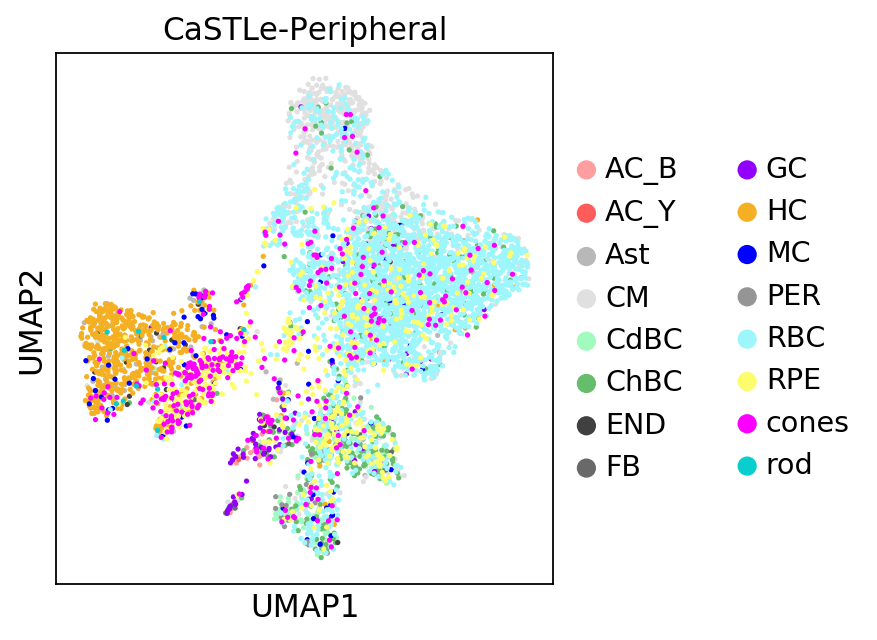

In [42]:

adata.uns['CaSTLe-Peripheral_colors'] = ['#FF9E9E',  '#FE5B5B',   '#B9B8B8', '#E0E0E0',
                                 '#A2FBBE', '#66BD6B', '#404040','#696969', '#9000FA',  '#F5AF22', 
                              '#0000FF', '#959595',  '#9CF6FC', '#FCFC6C',
                                   '#FC00FF', '#09CECE']
sc.pl.umap(adata, color=['CaSTLe-Peripheral'], save = "_CaSTLe_Annot_subtypes_Control3_Per.svg")

Prepare the pie charts

In [43]:
## Control sample 2

... reading from cache file ./cache/data-bioinf-projects-data-2018_scanpyTutorial-input-sc_hROHT-S2_CTRL_HRO1-outs-raw_gene_bc_matrices-hg38.e87-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 332278 cells that have less than 1 counts


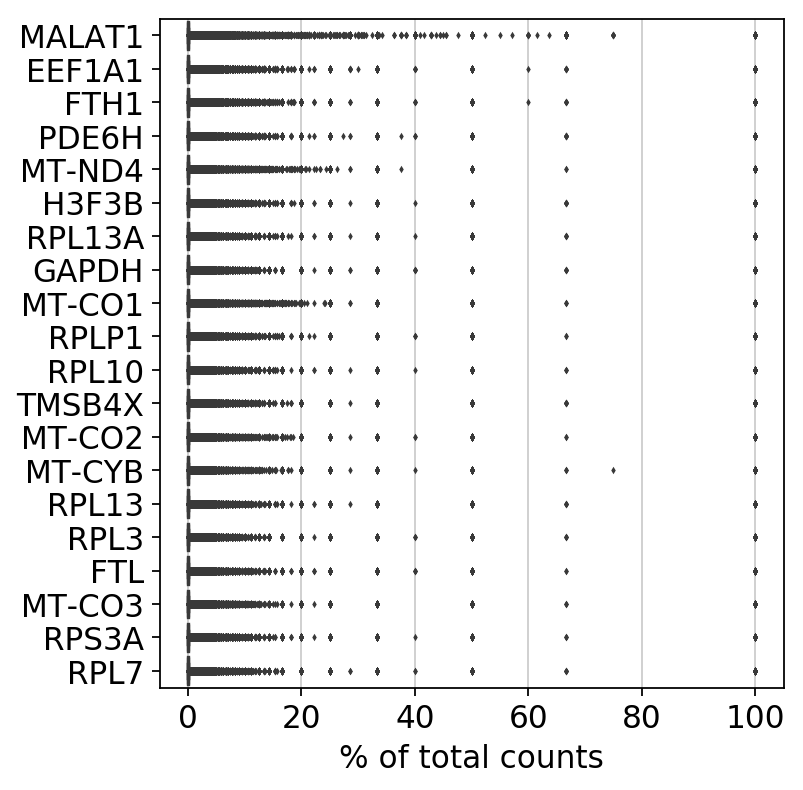

filtered out 727761 cells that have less than 200 genes expressed
filtered out 11292 genes that are detected in less than 3 cells
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/violinPT_Clust_Violin_Genes_Counts_Mito_CTRL_2.svg


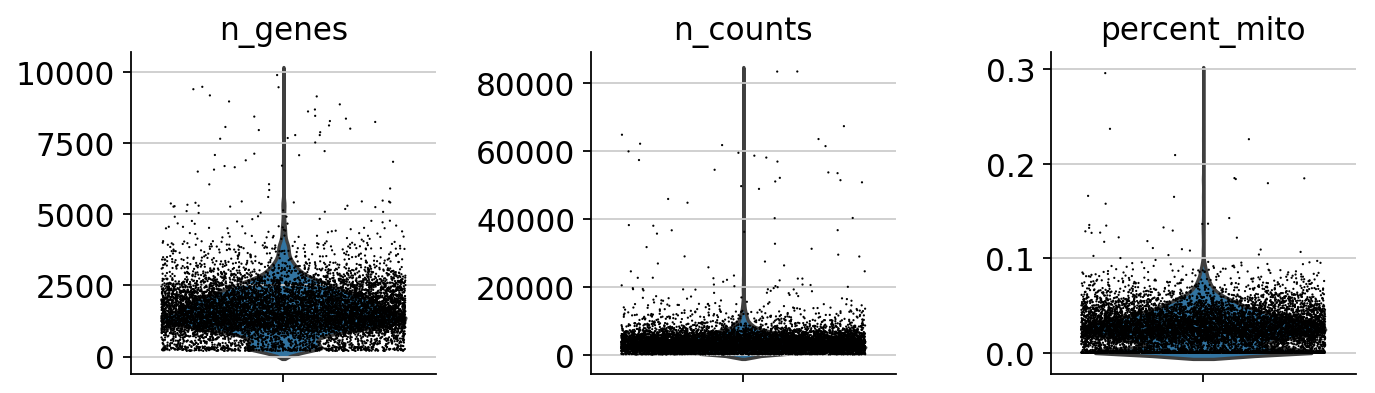

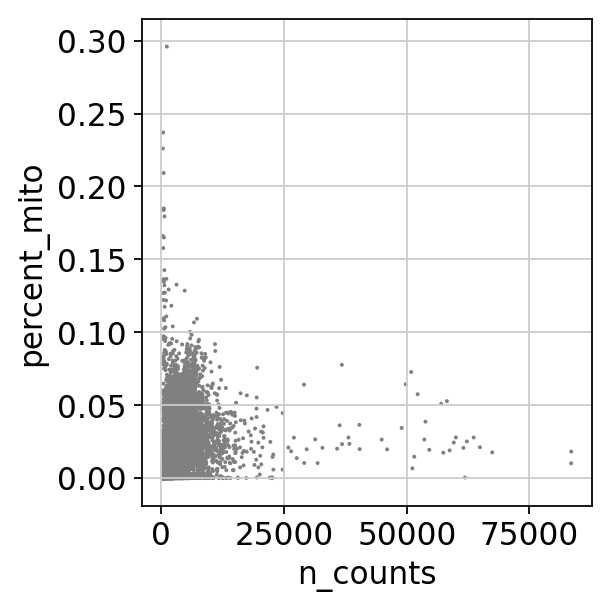

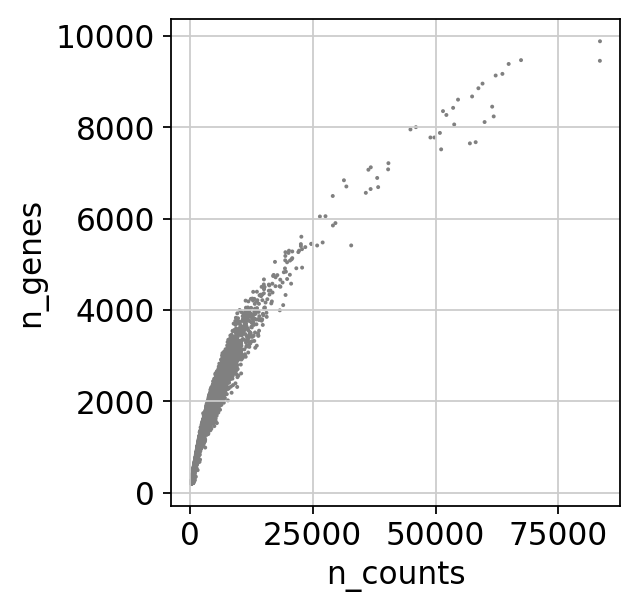

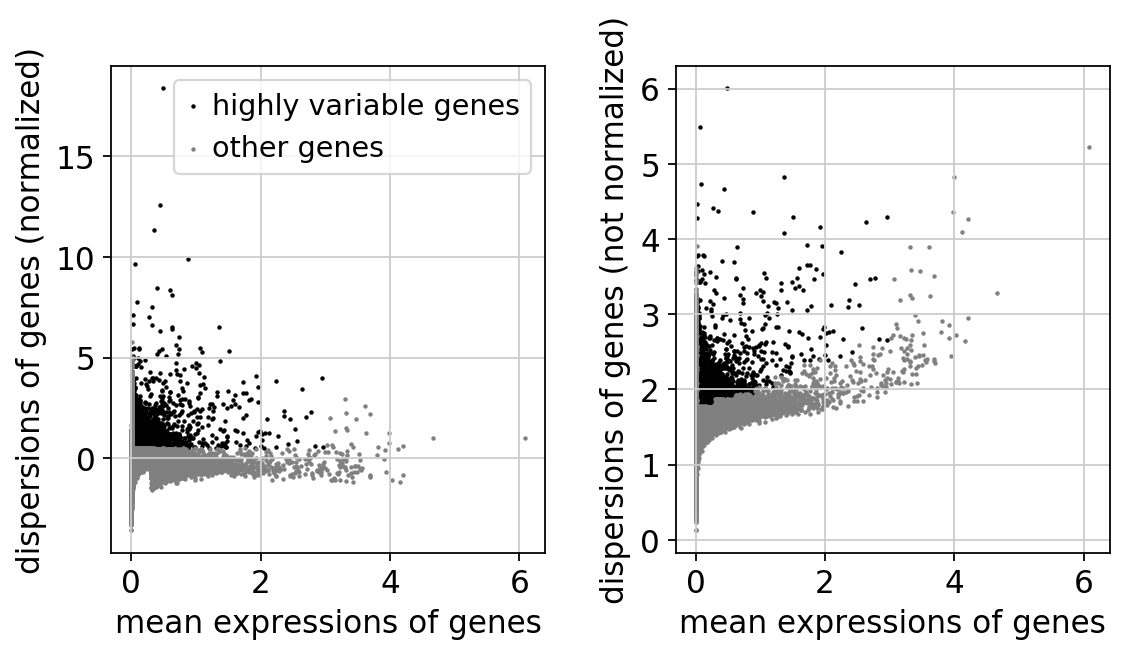

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.55)


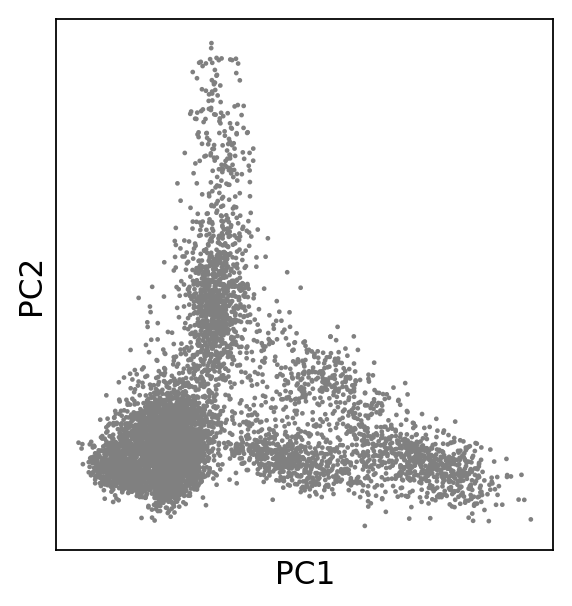

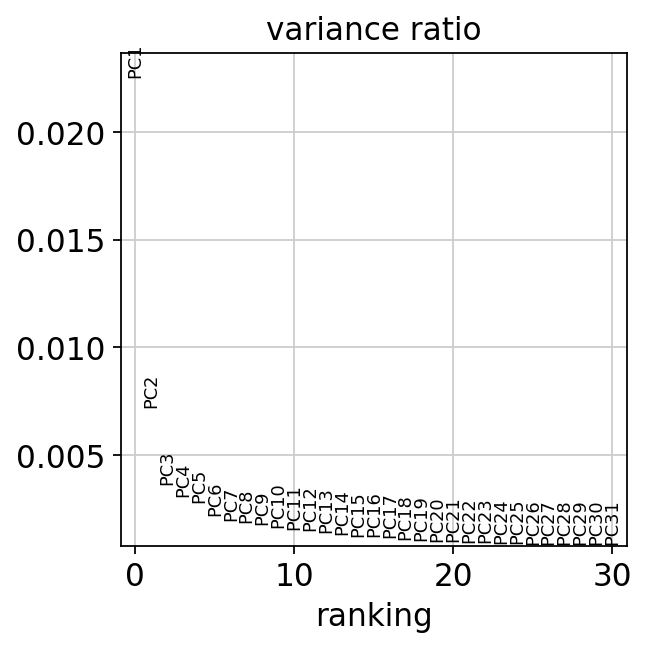

computing neighbors
    using 'X_pca' with n_pcs = 40


/global/apps/bioinf/conda_envs/public/scanpy/scanpy-1.3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:03.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:12.85) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.44) --> found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_LouvainClustering_CTRL_2_higherResolution.svg


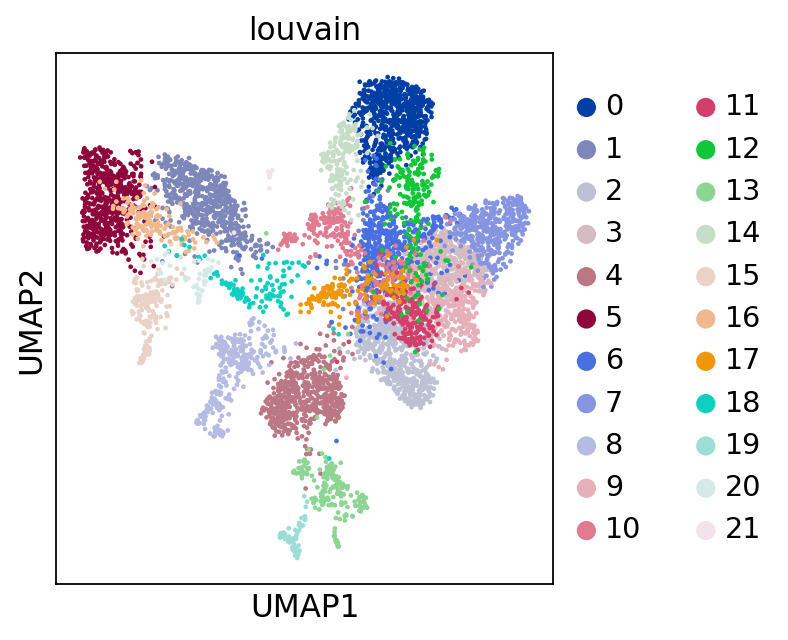

In [61]:
PreprocessSC(data_path = '/data/bioinf/projects/data/2018_scanpyTutorial/input/sc_hROHT/S2_CTRL_HRO1/outs/raw_gene_bc_matrices/hg38.e87/',
             data_type = 'CTRL_2')
ClusterCells(adata_input = adata, 
               cutoff_mito = 0.04, 
               cutoff_ngenes = 2500, 
               resolution_lv = 2, 
               data_type = 'CTRL_2_higherResolution')


... storing 'CaSTLe-Organoid' as categorical
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control2.svg


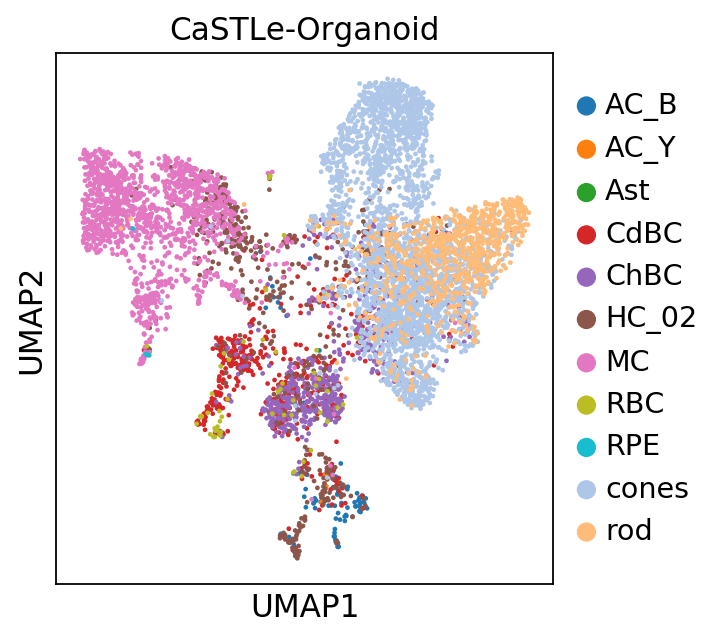

In [62]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_2_Organoid_cellnames.csv")
CaSTLE
adata.obs["CaSTLe-Organoid"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe-Organoid'], save = "_CaSTLe_Annot_subtypes_Control2.svg")

saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control2.svg


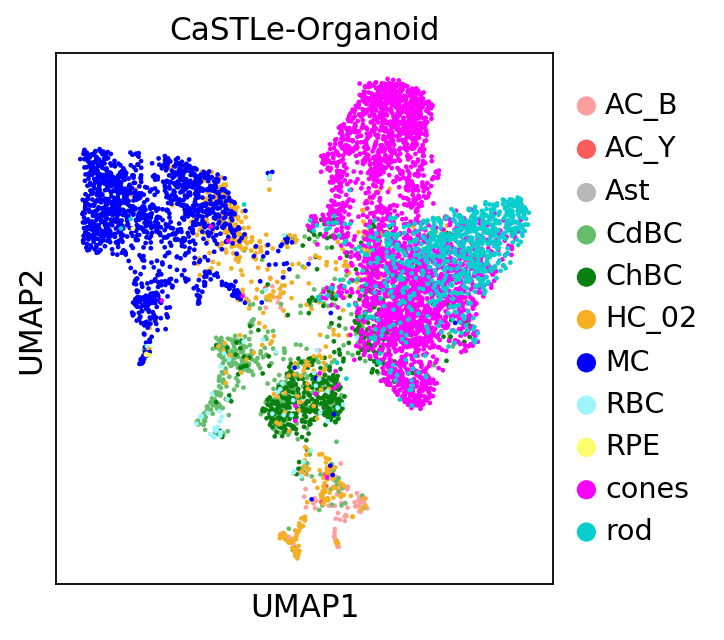

In [63]:
adata.uns['CaSTLe-Organoid_colors'] = ['#FF9E9E',  '#FE5B5B',  '#B9B8B8',
                              '#66BD6B', '#098010', '#F5AF22',  '#0000FF', 
                              '#9CF6FC', '#FCFC6C', '#FC00FF', '#09CECE']
sc.pl.umap(adata, color=['CaSTLe-Organoid'], save = "_CaSTLe_Annot_subtypes_Control2.svg")

In [64]:
adata.write("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/Data/HRO_2_CaSTLe.h5ad")

In [65]:
adata.obs["CaSTLe-Organoid"].to_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/Chapter9_CaSTLe_Annot_HRO2.csv")

... storing 'CaSTLe-Foveal' as categorical
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control2_Fov.svg


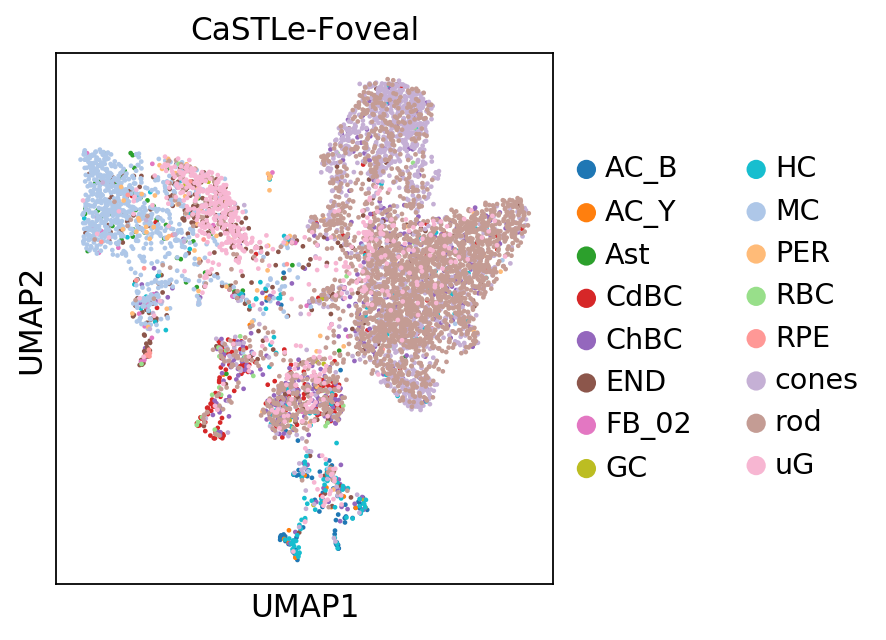

In [49]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_2_Foveal_cellnames.csv")
CaSTLE
adata.obs["CaSTLe-Foveal"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe-Foveal'], save = "_CaSTLe_Annot_subtypes_Control2_Fov.svg")

saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control2_Fov.svg


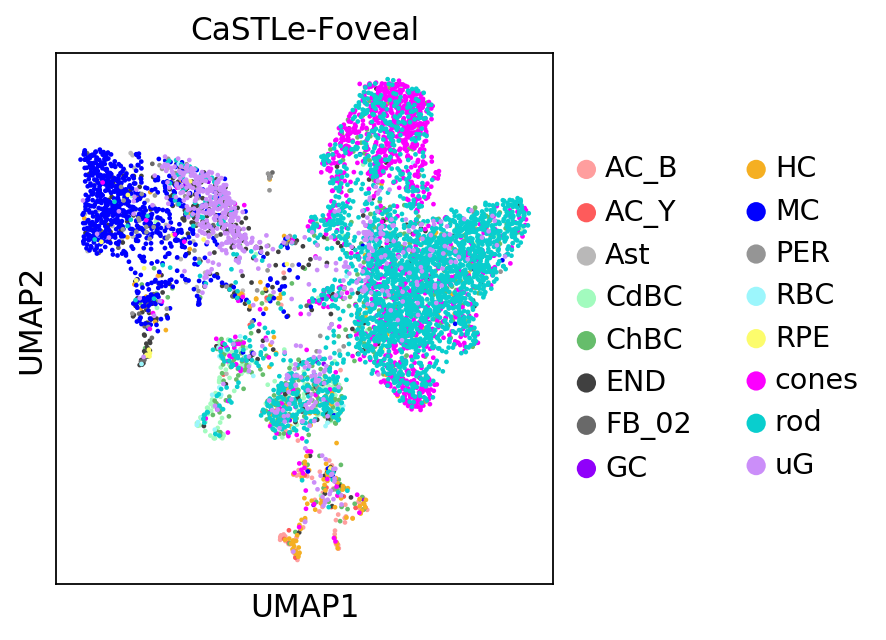

In [50]:
adata.uns['CaSTLe-Foveal_colors'] = ['#FF9E9E',  '#FE5B5B',   '#B9B8B8',
                                 '#A2FBBE', '#66BD6B', '#404040','#696969', '#9000FA',  '#F5AF22', 
                              '#0000FF', '#959595',  '#9CF6FC', '#FCFC6C',
                                   '#FC00FF', '#09CECE', '#CB8EF9']
sc.pl.umap(adata, color=['CaSTLe-Foveal'], save = "_CaSTLe_Annot_subtypes_Control2_Fov.svg")

... storing 'CaSTLe-Peripheral' as categorical
saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control2_Per.svg


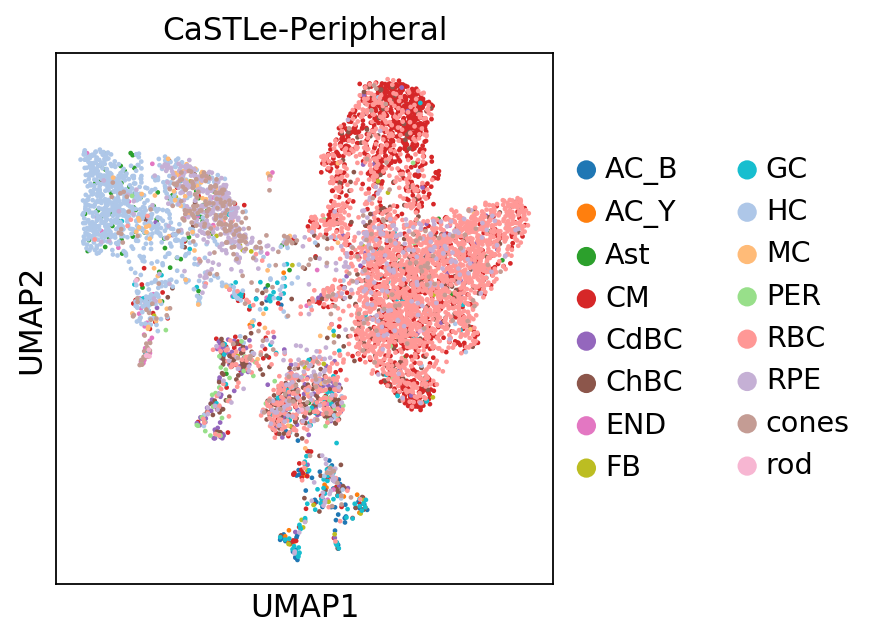

In [51]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_2_Peri_cellnames.csv")
CaSTLE
adata.obs["CaSTLe-Peripheral"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe-Peripheral'], save = "_CaSTLe_Annot_subtypes_Control2_Per.svg")


saving figure to file /data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/results/umap_CaSTLe_Annot_subtypes_Control2_Per.svg


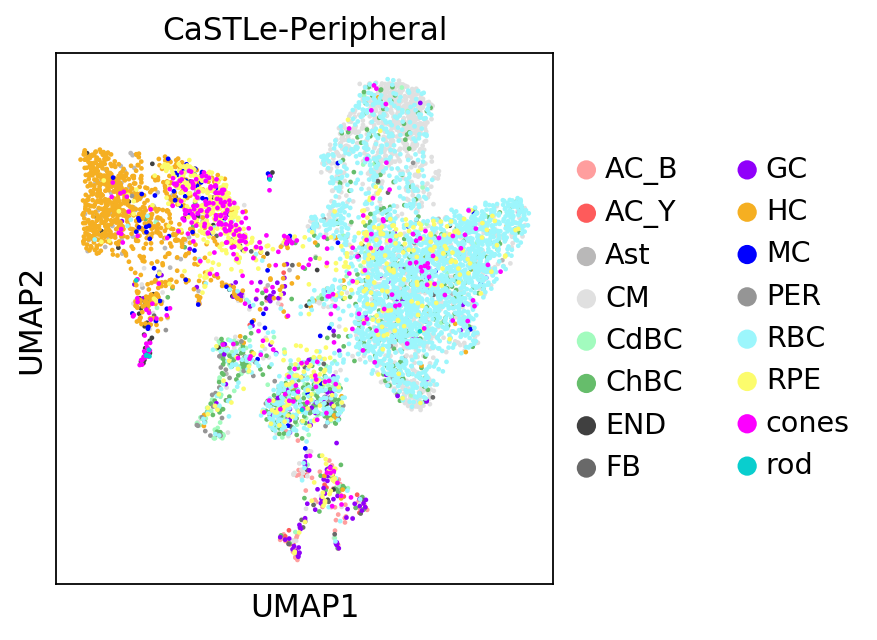

In [52]:
adata.uns['CaSTLe-Peripheral_colors'] = ['#FF9E9E',  '#FE5B5B',   '#B9B8B8', '#E0E0E0',
                                 '#A2FBBE', '#66BD6B', '#404040','#696969', '#9000FA',  '#F5AF22', 
                              '#0000FF', '#959595',  '#9CF6FC', '#FCFC6C',
                                   '#FC00FF', '#09CECE']
sc.pl.umap(adata, color=['CaSTLe-Peripheral'], save = "_CaSTLe_Annot_subtypes_Control2_Per.svg")